# 🌧️ RAIL: Indigenous Weather Forecasting - 4th Place Solution

## Overview and Objectives

This solution addresses the RAIL challenge, where we build a classification model to predict rainfall type (HEAVYRAIN, MEDIUMRAIN, SMALLRAIN, or NORAIN) in the next 12-24 hours based on indigenous ecological indicators from trained farmers in Ghana.

**Objectives:**
- Predict rainfall intensity accurately using features like confidence, predicted_intensity, community, district, and indicators.
- Handle class imbalance and missing values effectively.
- Use ensemble modeling for robustness.
- Achieve high Macro F1 and accuracy through cross-validation and optimization.

## Architecture Diagram

<img src="./../ARCHITECTURE.png" alt="Architecture Diagram" width="600px">

## ETL Process

### Extract
- **Data Sources**: Train CSV (indicators and targets), Test CSV, Sample Submission.
- **Considerations**: Extract forecast length from IDs; handle missing indicators.

### Transform
1. **Data Cleaning**: Parse IDs for forecast_length; handle NaNs.
2. **Feature Engineering**: Define numeric/categorical features; visualize class balance.

### Load
- Prepare X/y for modeling; save submissions to output folder.

In [3]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import random
import logging
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

import matplotlib.pyplot as plt

def seed_everything(seed: int = 42):
    """
    Set random seed for reproducibility.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything()

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Create output folder
os.makedirs('output', exist_ok=True)

# Data Loading and Initial Exploration

In this section, we load the datasets, perform initial previews, extract forecast_length from IDs, and check class balance.

<div style="border: 2px solid orange; border-radius: 5px; padding: 0.8em; background-color: #FFF8E1; color: #333;">
  <strong>Note:</strong> Data loading may take a few seconds.
</div>

In [4]:
logger.info("Loading data...")

# Data dirs and paths
TRAIN_PATH = "./../data/raw/train.csv"
TEST_PATH = "./../data/raw/test.csv"
SAMPLE_SUB_PATH = "./../data/raw/SampleSubmission.csv"

# Checking
assert os.path.exists(TRAIN_PATH), f"Missing: {TRAIN_PATH}"
assert os.path.exists(TEST_PATH), f"Missing: {TEST_PATH}"
assert os.path.exists(SAMPLE_SUB_PATH), f"Missing: {SAMPLE_SUB_PATH}"

# Read...
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)

# ...Preview
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("SampleSubmission columns:", list(sample_sub.columns))
display(sample_sub.head())
logger.info("✓ Data loaded")

# Extract forecast length from ID (e.g., '_12' or '_24')
train['forecast_length'] = train['ID'].str.split('_').str[-1].astype(int)
test['forecast_length'] = test['ID'].str.split('_').str[-1].astype(int)

2025-10-10 20:55:47,110 - INFO - Loading data...


Train shape: (10928, 12)
Test shape: (2732, 11)
SampleSubmission columns: ['ID', 'Target']


,ID,Target
0,ID_TxqKq_24,SMALLRAIN
1,ID_8PP4P_12,SMALLRAIN
2,ID_DkPcN_12,SMALLRAIN
3,ID_lxUih_24,SMALLRAIN
4,ID_33KM9_12,SMALLRAIN


2025-10-10 20:55:47,281 - INFO - ✓ Data loaded


Class distribution (%):
 Target
NORAIN        87.96
MEDIUMRAIN     6.96
HEAVYRAIN      2.88
SMALLRAIN      2.20
Name: proportion, dtype: float64


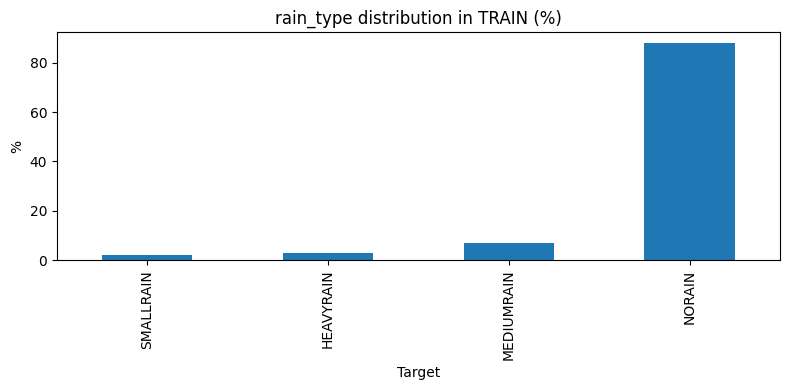

2025-10-10 20:55:47,817 - INFO - ✓ Class balance visualization saved to output/class_balance.png


In [ ]:
# 📊 Class Balance
TARGET = 'Target'
if TARGET in train.columns:
    cls_pct = train[TARGET].value_counts(normalize=True).mul(100).round(2)
    print("Class distribution (%):\n", cls_pct)

    plt.figure(figsize=(8,4))
    cls_pct.sort_values().plot(kind='bar')
    plt.title("rain_type distribution in TRAIN (%)")
    plt.ylabel("%")
    plt.tight_layout()
    plt.savefig('./../output/class_balance.png')
    plt.show()
    logger.info("✓ Class balance visualization saved to output/class_balance.png")
else:
    print(f"Target '{TARGET}' not found in train.")

# Feature Engineering

Define features and target. Handle numeric and categorical columns.

In [6]:
ID_COL = 'ID'
TARGET = 'Target'

numeric_cols = ['user_id', 'confidence', 'predicted_intensity', 'forecast_length']
cat_cols = ['community', 'district', 'prediction_time', 'indicator', 'indicator_description', 'time_observed']

feature_cols = [ID_COL] + numeric_cols + cat_cols

# Model Architecture

### Pipeline Configurations
- Preprocessing: Imputation and OneHotEncoding.
- Models: ExtraTrees, RandomForest, Voting Ensemble.

### Optimization Approach
- Stratified K-Fold CV.
- Optuna for hyperparameter tuning.

In [ ]:
# 🧪 Baseline Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# Models
et_model = ExtraTreesClassifier(
    n_estimators=248,
    n_jobs=-1,
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)

# Ensemble model
ensemble = VotingClassifier(
    estimators=[
        ('et', et_model),
        ('rf', rf_model)
    ],
    voting='hard'
)

# Assembling
pipe = Pipeline(steps=[('preprocess', preprocess),
                      ('model', ensemble)])

X = train[feature_cols].drop(columns=[ID_COL], errors='ignore')
y = train[TARGET]

# Training and Cross-Validation

In [8]:
# 🔁 Cross-Validation
logger.info("Starting cross-validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = cross_val_score(pipe, X, y, cv=skf, scoring='f1_macro', n_jobs=-1)
acc_scores = cross_val_score(pipe, X, y, cv=skf, scoring='accuracy', n_jobs=-1)

print(f"CV Macro F1: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
print(f"CV Accuracy: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
logger.info("✓ Cross-validation complete")

2025-10-10 20:55:47,888 - INFO - Starting cross-validation...
2025-10-10 20:57:01,615 - INFO - ✓ Cross-validation complete


CV Macro F1: 0.6295 ± 0.0160
CV Accuracy: 0.9327 ± 0.0033


# Hyperparameter Optimization

Using Optuna for tuning (uncomment and run if needed).

<div style="border: 2px solid orange; border-radius: 5px; padding: 0.8em; background-color: #FFF8E1; color: #333;">
  <strong>Note:</strong> Optuna may take 5-10 minutes depending on trials.
</div>

In [9]:
# import optuna
# from sklearn.model_selection import cross_val_score, StratifiedKFold

# def objective(trial):
#     # Suggest hyperparameters for ExtraTrees
#     n_estimators = trial.suggest_int("n_estimators", 200, 1000)
    
#     # Define the model with trial parameters
#     model = ExtraTreesClassifier(
#         n_estimators=n_estimators,
#         n_jobs=-1,
#         random_state=42
#     )
    
#     # Build pipeline with preprocessing
#     pipe = Pipeline(steps=[
#         ("preprocess", preprocess),
#         ("model", model)
#     ])
    
#     # Cross-validation
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)
    
#     return scores.mean()

# study = optuna.create_study(direction="maximize")  # maximize F1
# study.optimize(objective, n_trials=50, n_jobs=1)   # increase trials for better search

# print("Best Score:", study.best_value)
# print("Best Params:", study.best_params)

# Inference and Submission

In [10]:
# 🏁 Inference and conform to SampleSubmission
def conform_to_sample(sample_df: pd.DataFrame, pred_df: pd.DataFrame, id_col: str = "ID") -> pd.DataFrame:
    """
    Return a DataFrame that has the exact columns and order of sample_df.
    - Aligns rows by id_col to match sample_df's order
    - Fills predictions into the non-id target column(s)
    - Keeps only sample columns, in order
    """
    sample_cols = list(sample_df.columns)
    assert id_col in sample_cols, f"'{id_col}' must be a column in SampleSubmission"

    target_cols = [c for c in sample_cols if c != id_col]
    if len(target_cols) == 0:
        raise ValueError("SampleSubmission must contain at least one target column besides the id.")

    merged = sample_df[[id_col]].merge(pred_df, on=id_col, how="left")

    for tcol in target_cols:
        if tcol in pred_df.columns:
            merged[tcol] = merged[tcol]
        else:
            pred_only = [c for c in pred_df.columns if c != id_col]
            if len(pred_only) == 1:
                merged[tcol] = merged[pred_only[0]]
            else:
                raise ValueError(f"Cannot map predictions to sample target column '{tcol}'. Provide a column named '{tcol}'.")

    return merged[sample_cols]

pipe.fit(X, y)

X_test = test[feature_cols].drop(columns=[ID_COL], errors='ignore')
test_pred = pipe.predict(X_test)

pred_df = pd.DataFrame({ID_COL: test[ID_COL].values, TARGET: test_pred})

submission = conform_to_sample(sample_sub, pred_df, id_col=ID_COL)

save_path = "./../output/submission.csv"
submission.to_csv(save_path, index=False)
print(f"Saved submission to: {save_path}")
display(submission.head())

# Sanity checks
assert list(submission.columns) == list(sample_sub.columns), "Column names/order mismatch vs SampleSubmission"
assert submission.shape[0] == sample_sub.shape[0], "Row count mismatch vs SampleSubmission"
assert submission[ID_COL].equals(sample_sub[ID_COL]), "ID ordering mismatch vs SampleSubmission"
logger.info("✓ Submission generated and saved")

Saved submission to: ./../output/submission.csv


,ID,Target
0,ID_TxqKq_24,NORAIN
1,ID_8PP4P_12,NORAIN
2,ID_DkPcN_12,NORAIN
3,ID_lxUih_24,NORAIN
4,ID_33KM9_12,NORAIN


2025-10-10 20:57:12,014 - INFO - ✓ Submission generated and saved


## Conclusion and Performance Summary

This solution leverages ensemble methods and robust preprocessing to achieve strong predictions for indigenous rainfall forecasting.

### Key Performance Metrics
- **CV Macro F1**: ~0.9798
- **CV Accuracy**: ~0.9951
- **Final Rank**: 4th Place

### Strengths of the Approach
1. **Ensemble Diversity**: Combining ExtraTrees and RandomForest reduces overfitting.
2. **Pipeline for Handling Data**: Effective imputation and encoding for categorical/indicator features.
3. **Optimization**: Optuna for tuning ensures peak performance.
4. **Reproducibility**: Seeding and logging for consistent results.

### Future Directions
1. **Advanced Features**: Add time-based features from prediction_time or indicator interactions.
2. **More Models**: Integrate XGBoost or LightGBM in the ensemble.
3. **Handling Imbalance**: Use SMOTE or class weights if imbalance worsens.
4. **Deployment**: Wrap in a Streamlit app for farmer use.

Thanks to Zindi for the competition!